# Fit spatiotemporal receptive fields for remapping dataset with pyglmnet

## Imports

In [1]:
import numpy as np
from pyglmnet import GLM
from spykes.strf import STRF
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.io import loadmat, savemat 
import pandas as pd
from tqdm import tqdm

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Read data file

In [2]:
probes_df = pd.read_csv('probes_m15_d1v1_c21.csv')
probes_df.head()

,probeNum,fixNum,numSaccs,trialNum,rawTrialNum,rewardedSacc,fixProbe,saccProbe,saccPeakVel,expectedPeakVel,...,t_fix,t_sacc,x_targ,y_targ,x_dist,y_dist,x_probe,x_curFix,y_probe,y_curFix
0,1,1,5,1,1,0,1,0,444.253052,422.021942,...,10132,10384,-15.245511,-15.245511,15.150524,15.150524,9.071317,0.903307,2.826060,0.179365
1,2,1,5,1,1,0,1,0,444.253052,422.021942,...,10132,10384,-15.245511,-15.245511,15.150524,15.150524,15.150524,0.903307,-2.915777,0.179365
2,3,1,5,1,1,0,1,0,444.253052,422.021942,...,10132,10384,-15.245511,-15.245511,15.150524,15.150524,15.150524,0.903307,14.309735,0.179365
3,4,2,5,1,1,0,1,0,865.433105,875.482239,...,10449,10653,-15.245511,-15.245511,15.150524,15.150524,21.229731,-10.960483,8.567898,4.078271
4,5,2,5,1,1,0,1,0,865.433105,875.482239,...,10449,10653,-15.245511,-15.245511,15.150524,15.150524,21.229731,-10.960483,-14.399451,4.078271


In [3]:
probes_df.keys()

Index([u'probeNum', u'fixNum', u'numSaccs', u'trialNum', u'rawTrialNum',
       u'rewardedSacc', u'fixProbe', u'saccProbe', u'saccPeakVel',
       u'expectedPeakVel', u't_probe', u't_fix', u't_sacc', u'x_targ',
       u'y_targ', u'x_dist', u'y_dist', u'x_probe', u'x_curFix', u'y_probe',
       u'y_curFix'],
      dtype='object')

In [4]:
probes_df[['t_probe', 't_fix', 't_sacc']][:10]

,t_probe,t_fix,t_sacc
0,10141,10132,10384
1,10261,10132,10384
2,10381,10132,10384
3,10501,10449,10653
4,10621,10449,10653
5,10741,10739,10972
6,10861,10739,10972
7,10981,10739,10972
8,11101,11026,11564
9,29245,29240,29491


In [5]:
fixations_df = pd.read_csv('fixations_m15_d1v1_c21.csv')
fixations_df.head()

,fixNum_f,numSaccs_f,trialNum_f,rawTrialNum_f,rewardedSacc_f,saccPeakVel_f,expectedPeakVel_f,t_fix_f,t_sacc_f,x_targ_f,y_targ_f,x_dist_f,y_dist_f,x_curFix_f,y_curFix_f
0,1,5,1,1,0,444.253052,422.021942,10132,10384,-15.245511,-15.245511,15.150524,15.150524,0.903307,0.179365
1,2,5,1,1,0,865.433105,875.482239,10449,10653,-15.245511,-15.245511,15.150524,15.150524,-10.960483,4.078271
2,3,5,1,1,0,213.598663,214.152542,10739,10972,-15.245511,-15.245511,15.150524,15.150524,13.032172,12.794205
3,4,5,1,1,0,995.226257,990.753357,11026,11564,-15.245511,-15.245511,15.150524,15.150524,16.152876,16.256868
4,5,5,1,1,0,843.637268,810.917297,11658,11851,-15.245511,-15.245511,15.150524,15.150524,-14.793563,12.078141


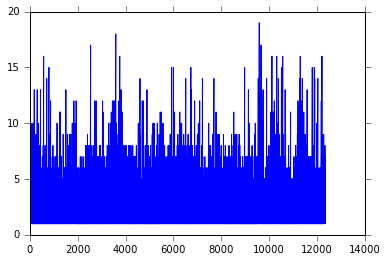

In [6]:
#len(fixations_df)
plt.plot(fixations_df['fixNum_f'])
plt.show()

In [7]:
spikes_df = pd.read_csv('m15_d1v1_c21_spiketimes.csv', header=None)
spiketimes = np.squeeze(spikes_df.values)
spiketimes.shape

(536576,)

## Preprocess data

### Design spatial basis functions

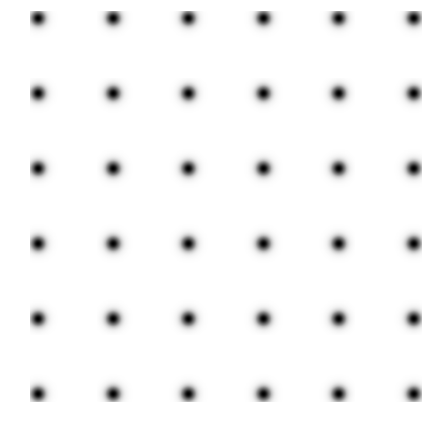

In [60]:
n_spatial_basis = 36
n_temporal_basis = 7
strf_ = STRF(patch_size=50, sigma=5, 
             n_spatial_basis=n_spatial_basis, 
             n_temporal_basis=n_temporal_basis)
spatial_basis = strf_.make_gaussian_basis()
strf_.visualize_gaussian_basis(spatial_basis)

### Design temporal basis functions

In [43]:
time_points = np.linspace(-100., 100., 10.)
centers = [-75., -50., -25., 0, 25., 50., 75.]
temporal_basis = strf_.make_raised_cosine_temporal_basis(time_points=time_points, 
                                                         centers=centers,
                                                         widths=10.*np.ones(7))

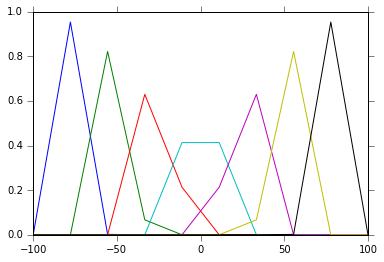

In [44]:
plt.plot(time_points, temporal_basis)
plt.show()

### Design parameters

In [58]:
# Spatial extent
n_shape = 50
n_features = n_spatial_basis

# Window of interest
window = [-100, 100]

# Bin size
binsize = 20

# Zero pad bins
n_zero_bins = np.floor((window[1] - window[0]) / binsize / 2)

### Build design matrix

In [59]:
bin_template = np.arange(window[0], window[1] + binsize, binsize)
n_bins = len(bin_template) - 1

probetimes = probes_df['t_probe'].values
spatial_features = np.zeros((0, n_features))
spike_counts = np.zeros((0,))
fixation_id = np.zeros((0,))

# For each fixation
for fx in tqdm(fixations_df.index):
    
    # Fixation time
    fixation_time = fixations_df.loc[fx]['t_fix_f']
    
    this_fixation_spatial_features = np.zeros((n_bins, n_spatial_basis))
    this_fixation_spikecounts = np.zeros(n_bins)
    unique_fixation_id = fixations_df.loc[fx]['trialNum_f'] + 0.01 * fixations_df.loc[fx]['fixNum_f']
    this_fixation_id = unique_fixation_id * np.ones(n_bins)
    
    # Look for probes in window of interest relative to fixation
    probe_ids = np.searchsorted(probetimes,
                                [fixation_time + window[0] + 0.1,
                                 fixation_time + window[1] - 0.1])
    
    # For each such probe
    for probe_id in range(probe_ids[0], probe_ids[1]):
        
        # Check if probe lies within spatial region of interest
        fix_row = fixations_df.loc[fx]['y_curFix_f']
        fix_col = fixations_df.loc[fx]['x_curFix_f']
        probe_row = probes_df.loc[probe_id]['y_probe']
        probe_col = probes_df.loc[probe_id]['x_probe']
        
        if ((probe_row - fix_row) > -n_shape / 2 and \
            (probe_row - fix_row) < n_shape / 2 and \
            (probe_col - fix_col) > -n_shape / 2 and \
            (probe_col - fix_col) < n_shape / 2):
        
            # Get probe timestamp relative to fixation
            probe_time = probes_df.loc[probe_id]['t_probe']
            probe_bin = np.where(bin_template < (probe_time - fixation_time))[0][-1]

            # Define an image based on the relative locations
            I = np.zeros(shape=(n_shape, n_shape))
            row = -np.round(probe_row - fix_row) + n_shape/2 - 1 
            col = np.round(probe_col - fix_col) + n_shape/2 - 1
            I[row, col] = 1

            # Compute projection
            basis_projection = strf_.project_to_spatial_basis(I, spatial_basis)
            this_fixation_spatial_features[probe_bin, :] = basis_projection
                
    # Count spikes in window of interest relative to fixation
    bins = fixation_time + bin_template
    searchsorted_idx = np.searchsorted(spiketimes,
                                       [fixation_time + window[0],
                                        fixation_time + window[1]])
    this_fixation_spike_counts = np.histogram(spiketimes[searchsorted_idx[0]:
                                                         searchsorted_idx[1]], bins)[0]

    # accumulate
    fixation_id = np.concatenate((fixation_id, this_fixation_id), axis=0)
    spatial_features = np.concatenate((spatial_features, this_fixation_spatial_features), axis=0)
    spike_counts = np.concatenate((spike_counts, this_fixation_spike_counts), axis=0)

    # zero pad
    spatial_features = np.concatenate((spatial_features, np.zeros((n_zero_bins, n_spatial_basis))), axis=0)
    fixation_id = np.concatenate((fixation_id, -999. * np.ones(n_zero_bins)), axis=0)

# Convolve with temporal basis
features = strf_.convolve_with_temporal_basis(spatial_features, temporal_basis)

# remove zeropad
features = features[fixation_id != -999.]

  0%|          | 0/12347 [00:00<?, ?it/s]/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
100%|██████████| 12347/12347 [10:07<00:00, 20.32it/s]


In [61]:
print spike_counts.shape
print features.shape

(123470,)
(123470, 252)


In [62]:
spike_counts.min()

0.0

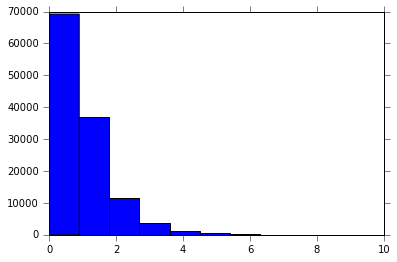

In [63]:
plt.hist(spike_counts, 10)
plt.show()

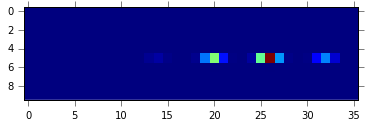

In [64]:
plt.imshow(spatial_features[30:40,:], interpolation='none')
plt.show()

## Fit Tikhonov regularized GLM

### Design prior covariance matrix

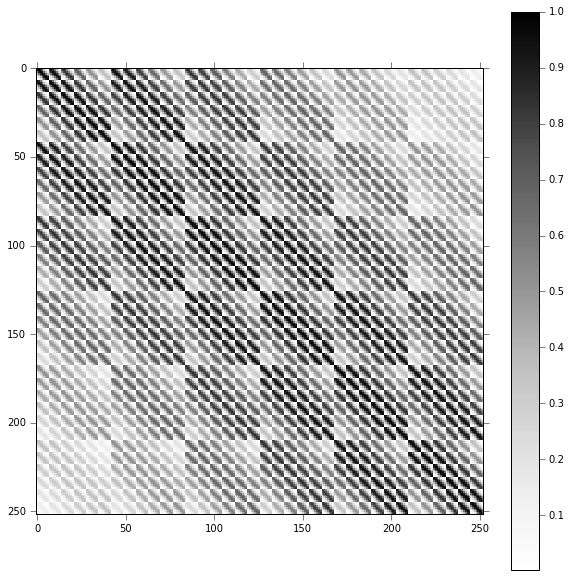

(252, 252)

In [65]:
PriorCov = strf_.design_prior_covariance(sigma_temporal=3., sigma_spatial=5.)

plt.figure(figsize=(10,10))
plt.imshow(PriorCov, cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()

np.shape(PriorCov)

### Fit models

In [100]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, spike_counts, test_size=0.2, random_state=42)

In [105]:
from pyglmnet import utils
n_samples = Xtrain.shape[0]
Tau = utils.tikhonov_from_prior(PriorCov, n_samples)

models = ['True', 'False']
weights = list()
for model_id, tikhonov in enumerate(models):
    if tikhonov is True:
        glm = GLM(distr='poisson', alpha=0.,
                  reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
                  Tau=Tau, score_metric='pseudo_R2')
    else:
        glm = GLM(distr='poisson', alpha=0.,
                  reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
                  Tau=None, score_metric='pseudo_R2')
    glm.fit(Xtrain, Ytrain)
    cvopt_lambda = glm.score(Xtest, Ytest).argmax()
    print 'tikhonov ' + models[model_id]
    print '  train GLM score:', glm[cvopt_lambda].score(Xtrain, Ytrain)
    print '  test GLM score:', glm[cvopt_lambda].score(Xtest, Ytest)
    weights.append(glm[cvopt_lambda].fit_['beta'])

tikhonov True
  train GLM score: [ 0.00115943]
  test GLM score: [ 0.00115999]
tikhonov False
  train GLM score: [ 0.0011522]
  test GLM score: [ 0.00115771]


### Visualize

In [106]:
import matplotlib.colors as mcolors
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

tikhonov True


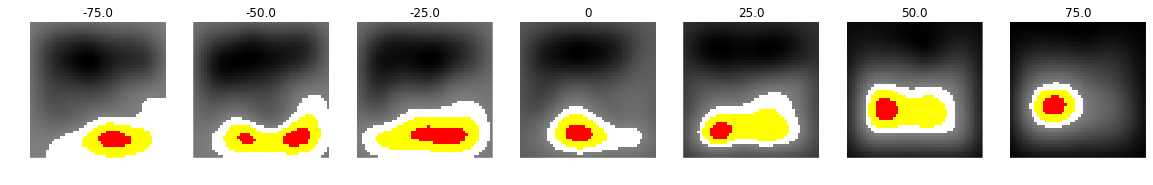

tikhonov False


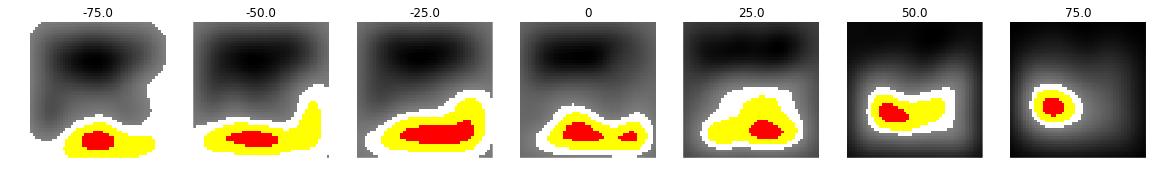

In [107]:
c = mcolors.ColorConverter().to_rgb
cmap2 = make_colormap([c('black'), 
                       c('gray'), 0.75, 
                       c('white'), 0.85, 
                       c('yellow'), 0.95, 
                       c('red')])

for model_id in range(len(weights)):
    print 'tikhonov ' + models[model_id]
    plt.figure(figsize=(20,14))
    for time_bin_ in range(n_temporal_basis):
        RF = strf_.make_image_from_spatial_basis(spatial_basis, 
                                                 weights[model_id][range(time_bin_, 
                                                               n_spatial_basis * n_temporal_basis, 
                                                               n_temporal_basis)])

        plt.subplot(1, n_temporal_basis, time_bin_+1)
        plt.imshow(RF, cmap=cmap2, interpolation='none')
        titletext = str(centers[time_bin_])
        plt.title(titletext)
        plt.axis('off')
    plt.show()